# Full Diagonalization implementation of 1D (chain) Heisenberg Model.

**Step 1**: Calculate Hilbert space dimension.

$$\mathcal{H}:(2s+1)^L$$ where $$s=1/2$$

**Step 2**: Create a list (or array) representing the indices of spins that are interacting (e.g. [[0,1], [..], ...]).

**Step 3**: Representing states as bits of an integer (e.g. for 4-spin system integer 1 is "0001", so '0' can be represented as '-1/2' and '1' as '1/2') (or) using a list containing the information about spins (e.g. {-1, 1, -1, 1} for a 4-spin lattice.).

Two ways of implementing:

    * Bitwise (Faster).

    * Lists (Simple but slower).

We will be doing the "Lists" way in the in-class demo. 

**Step 4**: Fill the diagonal matrix elements: 
$$\langle \ldots \sigma_i \ldots \sigma_j \ldots | H^{ij}_d | \ldots \sigma_i \ldots \sigma_j \ldots \rangle = \langle \ldots \sigma_i \ldots \sigma_j \ldots | J\big(s^z_is^z_j\big) | \ldots \sigma_i \ldots \sigma_j \ldots \rangle$$ 
where the spin states on the rest of sites apart $i$,$j$ indicated $\ldots$ are same for both the bra and the ket, e.g.

$$\langle \ldots \uparrow_i \ldots \uparrow_j \ldots | H^{ij}_d | \ldots \uparrow_i \ldots \uparrow_j \ldots \rangle = \langle \ldots \uparrow_i \ldots \uparrow_j \ldots | J\big(s^z_is^z_j\big) | \ldots \uparrow_i \ldots \uparrow_j \ldots \rangle = \frac{J}{4},$$
$$\langle \ldots \uparrow_i \ldots \downarrow_j \ldots | H^{ij}_d | \ldots \uparrow_i \ldots \downarrow_j \ldots \rangle = \langle \ldots \uparrow_i \ldots \downarrow_j \ldots | J\big(s^z_is^z_j\big) | \ldots \uparrow_i \ldots \downarrow_j \ldots \rangle = -\frac{J}{4}.$$


**Step 5**: Fill the non-zero off-diagonal matrix elements: 
 $$\langle \ldots \sigma'_i \ldots \sigma'_j \ldots | H^{ij}_{od} | \ldots \sigma_i \ldots \sigma_j \ldots \rangle = \langle \ldots \sigma'_i \ldots \sigma'_j \ldots | \frac{J}{2}\big(s^+_is^-_j + s^-_is^+_j\big) | \ldots \sigma_i \ldots \sigma_j \ldots \rangle.$$

Recall the rule, that if $\sigma_i == \sigma_j$, then the above matrix element $=0$, while if $\sigma_i == -\sigma_j$, then the above matrix element can be $=\frac{J}{2}$ provided $\sigma'_i == -\sigma_i$ and
$\sigma'_j == -\sigma_j$, e.g. 

$$\langle \ldots \downarrow_i \ldots \uparrow_j \ldots | H^{ij}_{od} | \ldots \uparrow_i \ldots \downarrow_j \ldots \rangle = \langle \ldots \downarrow_i \ldots \uparrow_j \ldots | \frac{J}{2}\big(s^+_is^-_j + s^-_is^+_j\big) | \ldots \uparrow_i \ldots \downarrow_j \ldots \rangle = \frac{J}{2},$$
$$\langle \ldots \uparrow_i \ldots \uparrow_j \ldots | H^{ij}_{od} | \ldots \uparrow_i \ldots \uparrow_j \ldots \rangle = \langle \ldots \uparrow_i \ldots \uparrow_j \ldots | \frac{J}{2}\big(s^+_is^-_j + s^-_is^+_j\big) | \ldots \uparrow_i \ldots \uparrow_j \ldots \rangle = 0.$$


**Step 6**: Diagonalize using the python library "linalg.eig" (for symmetric or hermitian matrices).

In [9]:
# -*- coding: utf-8 -*
from __future__ import absolute_import, division, print_function
import itertools
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



def flip(l0, l1):         # Operation of flipping spins, lo, l1 = {-1,1}
    if (l0 == -1 and l1 == 1):
     return [[1, -1]]
    if (l0 == 1 and l1 == -1):
     return [[-1, 1]]

def basis_no(i,S):              # Convert spin configuration into appropriate index. Should be Bijective
    L=len(i)
    z=0
    for j in range(L):
        z += (S**j)*int((i[L-j-1]+1)/2)
    return z


def save(file,X,Y):
    np.savetxt(file, list(zip(X, Y)), fmt='%.12g')      # Save the file


def energy(T,W):       # Energy function, input is the eigenvalue matrix
    enrg=0
    Z=0
    for i in range(len(W)):
        Z       += np.exp(-(W[i])/T)           # Partition function
        enrg    += W[i]*np.exp(-W[i]/T)        # Energy ensemble average
    return (enrg/Z)  

def get_hamiltonian(L, J, s):
    S = int(round(2*s))+1    # Effective spin in the system
    nhil = S**L   # Hilbert space-dimension
    bonds = [[(i+j)%L for i in range(2)] for j in range(L)] # Array containing the interaction pairs
    H = np.zeros((nhil,nhil),dtype=np.float128) # Initialize the Hamiltonian Matrix
    for ii in itertools.product([-1,1], repeat=L): # Going through the Hilbert space loop
        diag_energy = 0     
        for bond in bonds: # Go through the bonds loop
            diag_energy+= -(J-J*(ii[bond[0]]*ii[bond[1]]))*s*s # Calculate the sum of diagonal matrix elements
            if ii[bond[0]] == ii[bond[1]]: # Parallel spins dont contribute to off-diaganal operator
               continue
            kk = flip(ii[bond[0]], ii[bond[1]]) # Flip and store the new config in kk
            for j in kk:
                jj = ii                
                jj = list(jj)
                jj[bond[0]]=j[0] 
                jj[bond[1]]=j[1] 
                jj = tuple(jj)

                H[basis_no(ii,S)][basis_no(jj,S)]=J*s
        H[basis_no(ii,S)][basis_no(ii,S)]=diag_energy
    return H 


def full_ED(L, J, s):
    X=[]
    Y=[]
    for T in np.arange(0.1,2.0,0.01):
        H = get_hamiltonian(L, J, s)
        W = sp.linalg.eigh(H, eigvals_only=True)
        e = energy(T,W)
        #print("Energy per spin at T =", T, "is,", e/L)
        X = np.append(X, np.array([T]))
        Y = np.append(Y, np.array([e/L]))
    save("enrg_"+str(J)+"_"+str(L)+".dat",list(X),list(Y)) 

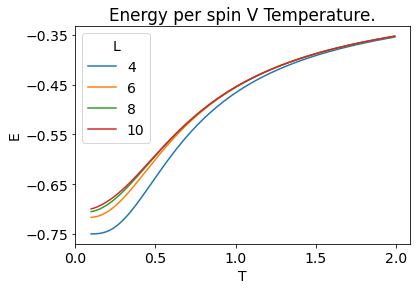

In [10]:
if __name__ == '__main__':
    L = 4
    J = 1.0
    s = 1/2
    plt.rcParams['font.size'] = '14'     
    fig, ax = plt.subplots()
    for i in range(4):
        full_ED(L, J, s)
        X, Y = np.genfromtxt("enrg_"+str(J)+"_"+str(L)+".dat", unpack=True, dtype=np.float128)
        plt.plot(X, Y, label=L)
        L += 2
    plt.xlabel('T')
    plt.ylabel('E')
    plt.xticks(np.arange(0, max(X)+0.5, 0.5))
    plt.yticks(np.arange(-0.75, max(Y)+0.1, 0.1))
    plt.title('Energy per spin V Temperature.')
    plt.legend(title='L')
    plt.show()

# Power Method:
* Iterative method for eigenvalue problems (e.g. say L=8).
* Aim is to get the approximate ground state eigenvalue and it's eigenvector.
* Especially useful when there is no symmetry in the Hamiltonian. 
* compare output from this method to what you obtained above
* need to subtract appropriate constant to ensure that ground state has maximal eigenvalue
* Recall the hint discussed in class, i.e. $$H^{ii}_d=J\big(s^z_is^z_j - s^2\big).$$

In [8]:
# Get Eigen value
def eigenvalue(A, v):
    Av = A.dot(v)
    return v.dot(Av)

# Iteration through m
def power_iteration(A): 
    n, d = A.shape            # Get the Matrix dimensions.
    A = -A + 5*np.identity(d) # Shift the matrix.
    v = np.random.randint(-d, d, size=d) # Pick a random vector or matrix. 
    v = v / np.linalg.norm(v) # Normalize it, Don't forget this step.
    ev = eigenvalue(A, v)     # Get the eigenvalue (through dot product)

    while True:
        Av = A.dot(v) # Acting the H operator on the random vector, new vector is Av
        v_new = Av / np.linalg.norm(Av) # Renormalize the new vector

        ev_new = eigenvalue(A, v_new) # Convergence check throug their eigenvalues (previous and current iteration)
        if np.abs(ev - ev_new) < 1e-15: # Stop if the convergence is reached with a toleracne of 1e-7
            break

        v = v_new     # Else, continue with next iteration.
        ev = ev_new

    return ev_new, v_new


# Main Loop
if __name__ == '__main__':
    L = 4
    J = 1.0
    s = 1/2    
    H = get_hamiltonian(L, J, s)
    print(H)
    W, V = power_iteration(H)
    print(-(W-5)/L)

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.  -1.  -0.5  0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.  -0.5 -1.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -1.   0.  -0.5  0.   0.   0.   0.  -0.5  0.   0.   0.
   0.   0. ]
 [ 0.   0.  -0.5  0.  -1.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -0.5  0.  -2.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5 -1.   0.   0.   0.  -0.5  0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.  -0.5  0.   0.
  -0.5  0. ]
 [ 0.  -0.5  0.   0.  -0.5  0.   0.   0.  -1.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0.  -1.  -0.5  0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5 -2.   0.  -0.5  0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.  -1.   0.  -0.5
   0